<a href="https://colab.research.google.com/github/GUNA1112/ml-projects/blob/main/Guna_Copy_of_FINAL_PROJECT_Lung_Cancer_Detection_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

source_folder = '/content/lung_n'
destination_folder = '/content/lung_image_sets'

shutil.move(source_folder, destination_folder)

In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/dataset/archive (2).zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


In [ ]:
path = '/content/lung_colon_image_set'
classes = []
for folder in os.listdir(path):
    sub_path = os.path.join(path, folder)
    if os.path.isdir(sub_path):
        for sub_folder in os.listdir(sub_path):
            classes.append(os.path.join(folder, sub_folder))

print(classes)

['lung_image_sets/lung_scc', 'lung_image_sets/lung_n', 'lung_image_sets/lung_aca', 'colon_image_sets/colon_n', 'colon_image_sets/colon_aca']


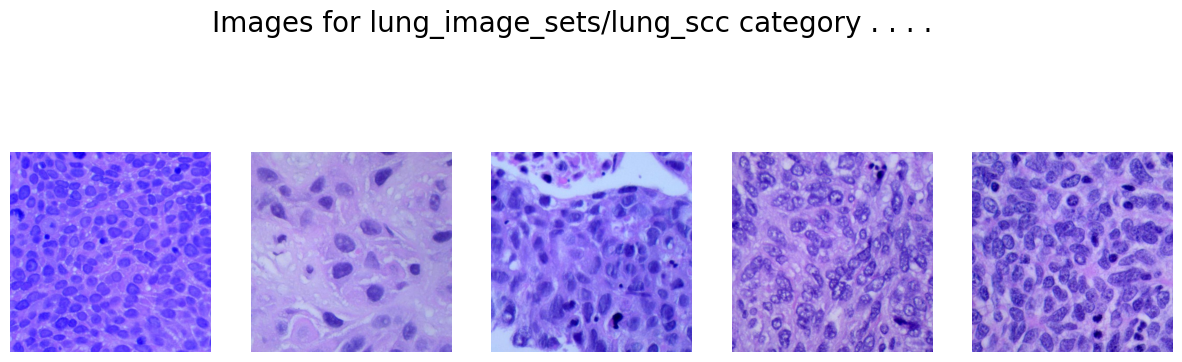

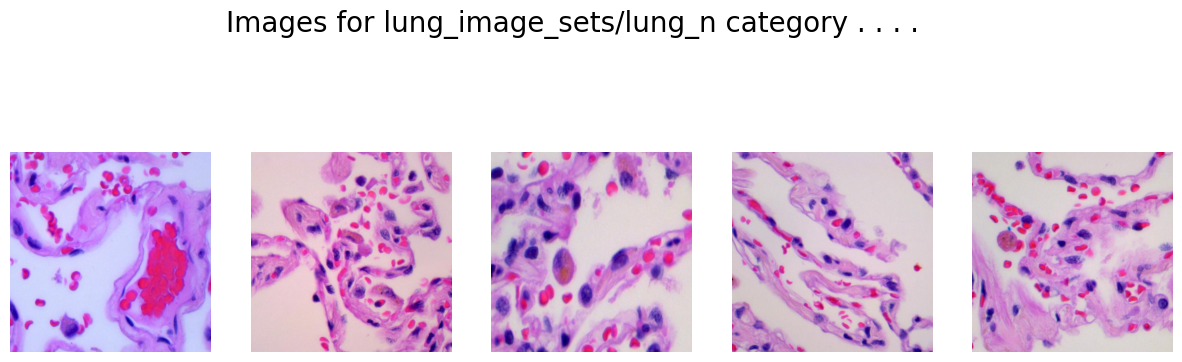

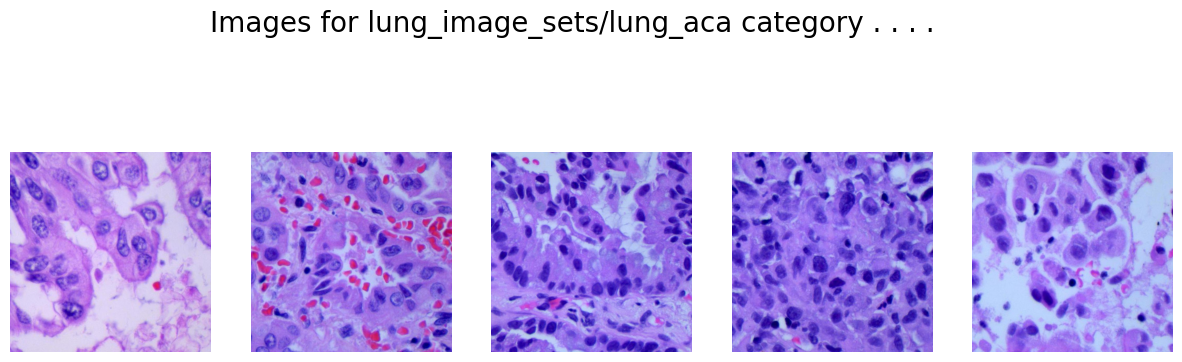

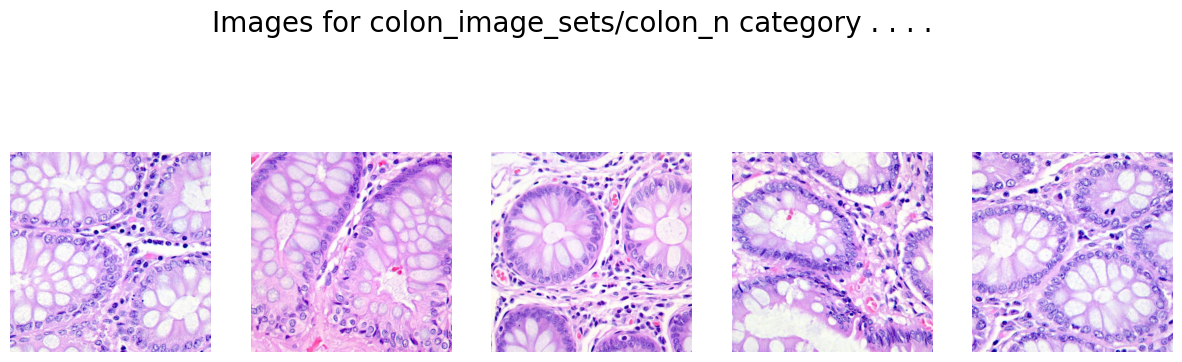

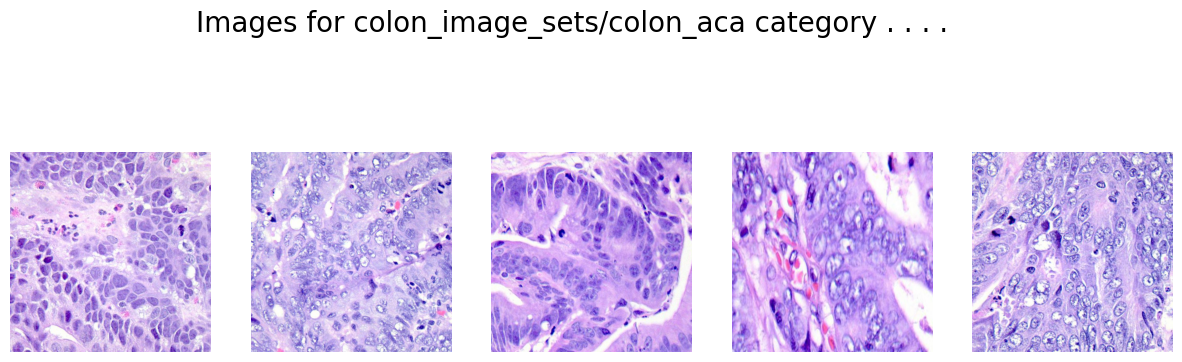

In [ ]:
path = '/content/lung_colon_image_set'
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 5, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category . . . .',
                 fontsize = 20)

    for i in range(5):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [ ]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 128

In [ ]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)

(20000, 256, 256, 3) (5000, 256, 256, 3)


In [ ]:
model = keras.Sequential([
       layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
       layers.MaxPooling2D((2, 2)),
       layers.Conv2D(64, (3, 3), activation='relu'),
       layers.MaxPooling2D((2, 2)),
       layers.Conv2D(128, (3, 3), activation='relu'),
       layers.MaxPooling2D((2, 2)),
       layers.Flatten(),
       layers.Dense(256, activation='relu'),
       layers.BatchNormalization(),
       layers.Dense(128, activation='relu'),
       layers.Dropout(0.3),
       layers.BatchNormalization(),
       layers.Dense(5, activation='softmax')
   ])


In [ ]:
model.compile(
         optimizer=keras.optimizers.Adam(learning_rate=0.002),  # Adjust learning rate here
         loss='categorical_crossentropy',
         metrics=['accuracy']
     )

1/1 [==============================] - 0s 58ms/step


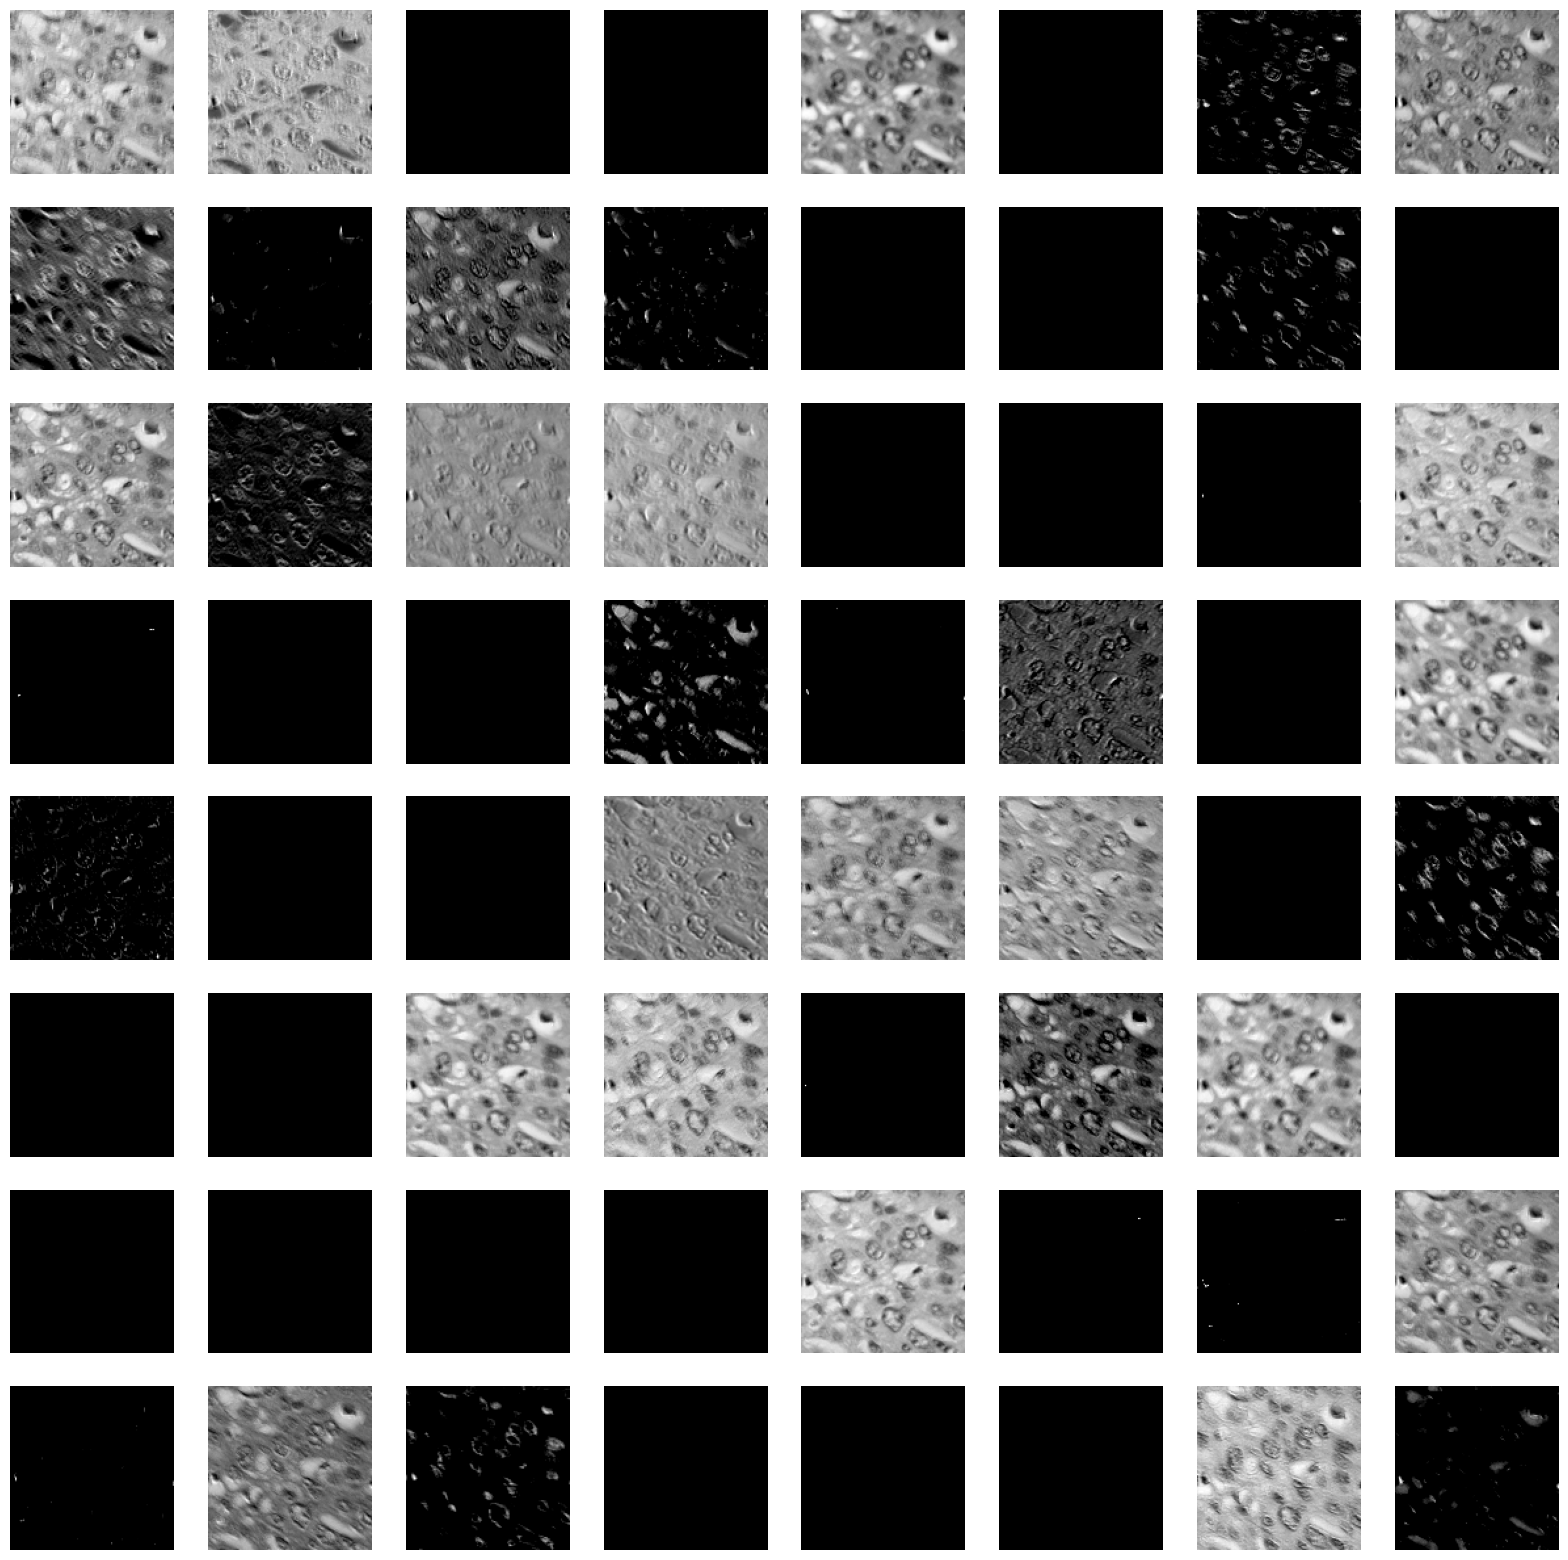

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf # Importing tensorflow

layer_name = 'conv2d_7'  # Replace with the name of your convolutional layer
# Build the model by calling it with an input shape
# This is crucial for model.input to be defined
_ = model(tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
layer_output = model.get_layer(layer_name).output
intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer_output) # Using tf.keras.Model

img = X_train[0]  # Choose an image from your training data
img = np.expand_dims(img, axis=0)  # Add batch dimension
img = img.astype(np.float32) / 255.0

feature_maps = intermediate_model.predict(img)

# Visualize the feature maps
num_filters = feature_maps.shape[-1]
plt.figure(figsize=(20, 20))
for i in range(num_filters):
    plt.subplot(8, 8, i + 1)  # Adjust subplot grid as needed
    plt.imshow(feature_maps[0, :, :, i], cmap='gray')  # Or 'viridis'
    plt.axis('off')
plt.show()

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.90:
      print('\n Validation accuracy has reached upto 90%\
      so, stopping further training.')
      self.model.stop_training = True

es = EarlyStopping(patience = 3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)

In [ ]:
es = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    class_weight=class_weights_dict,  # Add class weights here
                    callbacks=[es, lr, myCallback()])

Epoch 1/10
157/157 [==============================] - 323s 2s/step - loss: 0.4451 - accuracy: 0.8112 - val_loss: 1.4623 - val_accuracy: 0.6278 - lr: 0.0020
Epoch 2/10
157/157 [==============================] - 318s 2s/step - loss: 0.2259 - accuracy: 0.9147 - val_loss: 5.8673 - val_accuracy: 0.3942 - lr: 0.0020
Epoch 3/10
157/157 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9250
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
157/157 [==============================] - 318s 2s/step - loss: 0.1965 - accuracy: 0.9250 - val_loss: 8.1927 - val_accuracy: 0.4032 - lr: 0.0020
Epoch 4/10
157/157 [==============================] - 318s 2s/step - loss: 0.1478 - accuracy: 0.9464 - val_loss: 3.9761 - val_accuracy: 0.4184 - lr: 0.0010


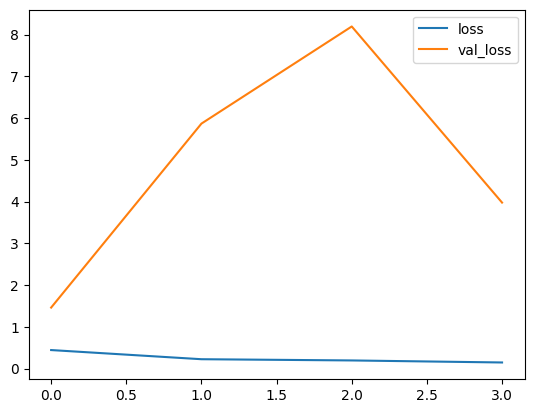

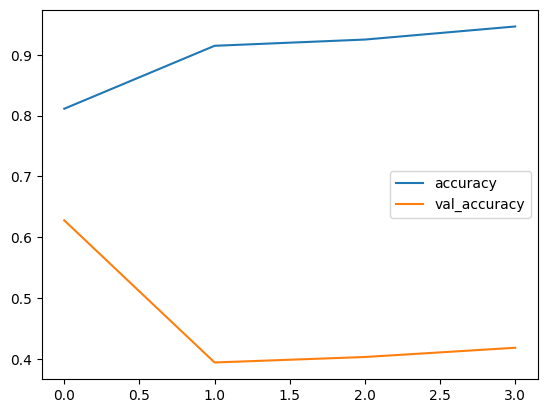

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [ ]:
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

157/157 [==============================] - 16s 103ms/step


In [ ]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[ 942,   25,    0,    0,    0],
       [   0, 1019,    0,    0,    0],
       [ 535,  475,    0,    0,    0],
       [   2,   73,    0,  922,    2],
       [ 460,  114,    0,  175,  256]])

In [ ]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))

                            precision    recall  f1-score   support

  lung_image_sets/lung_scc       0.49      0.97      0.65       967
    lung_image_sets/lung_n       0.60      1.00      0.75      1019
  lung_image_sets/lung_aca       0.00      0.00      0.00      1010
  colon_image_sets/colon_n       0.84      0.92      0.88       999
colon_image_sets/colon_aca       0.99      0.25      0.41      1005

                  accuracy                           0.63      5000
                 macro avg       0.58      0.63      0.54      5000
              weighted avg       0.58      0.63      0.54      5000

